# To start off, I want to get acquainted with derivatives.

We first need to import a few libraries to help visualize and work through the arithmetic. We will also use numpy to generate random numbers later on.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Lets say that we have a function f(x) and
# we want to see how important each of the
# variables are for the final output of the
# function.
# We can slightly increment one of the variables
# and compare the output of the function call
# before and after we nudged the variable.

In [3]:
def f(x):
    return 4*x**2 + 3*x + 10

In [4]:
f(3.0)

55.0

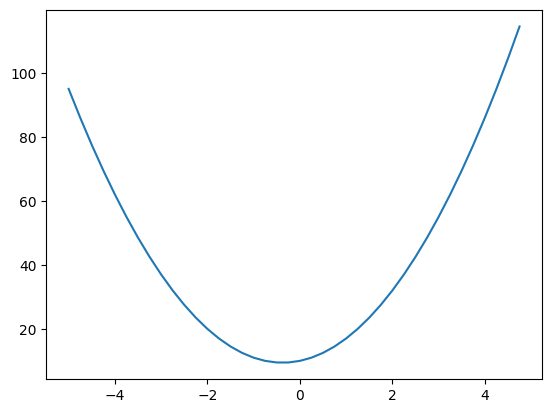

In [5]:
xs = np.arange(start=-5, stop=5, step=0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.001
x = -2.0
(f(x+h) - f(x))/h

-12.995999999997565

This shows the slope between the two points:
f(x) and f(x+h).

These slopes can be used to determine how variables affect the outcome of a mathematical expression. We are ultimately taking the derivative of a function with multiple inputs.

In [7]:
a = 2.0
b = -3.0
c = 10.0

h = 0.001

In [8]:
original = a * b + c
a += h
nudged = a * b + c

print("nudged function output: ", nudged)
print("original function output:", original)
print("slope: ", (nudged - original) / h)

nudged function output:  3.997
original function output: 4.0
slope:  -3.0000000000001137


In [9]:
original = a * b + c
b += h
nudged = a * b + c

print("nudged function output: ", nudged)
print("original function output:", original)
print("slope: ", (nudged - original) / h)

nudged function output:  3.999001
original function output: 3.997
slope:  2.0009999999999195


These slope outputs make sense because when taking the partial derivative with respect to a or b, in this instance, the equations result in their multiplicative counterpart:  
$d/da(a * b + c)$  &emsp; &emsp; &emsp; &emsp;                          $d/db(a * b + c)$  
$= d/da(ab) + d/da(c)$  &emsp;                                          $= d/db(ab) + d/db(c)$  
$= a^0 * b + 0$  &emsp;  &emsp; &emsp; &emsp; &ensp; &ensp;             $= a * b^0 + 0$  
$= b$  &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &ensp;   $= a$
  

Now when differentiating with respect to c, a constant, it will increase at a rate of 1 since it has no effect on the other variables other than the value being added.

In [10]:
original = a * b + c
c += h
nudged = a * b + c

print("nudged function output: ", nudged)
print("original function output:", original)
print("slope: ", (nudged - original) / h)

nudged function output:  4.000000999999999
original function output: 3.999001
slope:  0.9999999999994458


# Moving on to micrograd

When building out micrograd, we are going to need to make a Value object. We need a Value object to keep track of the children of the expression when doing backpropagation later.

In [11]:
class Value():
    def __init__(self, val):
        self.val = val
    def __repr__(self):
        return(f"Value(val={self.val})")

In [12]:
x = 4.0
Value(x)

Value(val=4.0)

Now we want to be able to add or multiply two value objects together

In [13]:
class Value():
    def __init__(self, val, _children=(), _op=''):
        self.val = val
        # prev is stored as a set, as opposed  
        # to a tuple, for efficiency.
        self.prev = set(_children)
        self._op = _op
        self.grad=0
    def __repr__(self):
        return(f"Value(val={self.val})") 
    def __add__(self, other):
        out = Value(self.val+other.val, (self, other), '+')
        return out
    def __mul__(self, other):
        out = Value(self.val*other.val, (self, other), '*')
        return out

In [14]:
a = Value(2.0)
b = Value(3.0)
print("a+b: ", a+b)
print("a*b: ", a*b)

x = a+b
print(x.prev)
print("operator: ", x._op)

a+b:  Value(val=5.0)
a*b:  Value(val=6.0)
{Value(val=2.0), Value(val=3.0)}
operator:  +


Now I want to add backpropagation (partial derivatives), and an activation function to our Value object

In [15]:
class Value():
    def __init__(self, val, _children=(), _op=''):
        self.val = val
        # prev is stored as a set, as opposed  
        # to a tuple, for efficiency.
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self._backward = lambda:None    # initialized to an empty lambda function

    def __repr__(self):
        return(f"Value(val={self.val})") 
    
    def __add__(self, other):
        out = Value(self.val+other.val, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad     # Note: the gradients have to accumulate (+=) to avoid issues 
            other.grad += 1.0 * self.grad   #       where a variable is used in an expression more than once.
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.val*other.val, (self, other), '*')
        def _backward():
            self.grad += other.val * out.grad
            other.grad += self.val * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.val
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.val
        out = Value(math.exp(x) / 1 + (math.exp(x)), (self, ), 'sigmoid')
        def _backward():
            self.grad = math.exp(x) / ((math.exp(x) + 1) ** 2)
        out._backward = _backward
        return out
    

In [16]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
x1w1 = x1 * w1
x2w2 = x2 * w2
b = Value(6.8813735870195432)
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()

In [17]:
o.grad = 1.0
o._backward()

In [18]:
n.grad
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()


In [19]:
print("x1: ", x1.grad)
print("x2: ", x2.grad)
print("w1: ", w1.grad)
print("w2: ", w2.grad)
print("x1w1: ", x1w1.grad)
print("x1w2: ", x2w2.grad)
print("x1w1x2w2: ", x1w1x2w2.grad)
print("n: ", n.grad)
print("o: ", o.grad)

x1:  -1.4999999999999996
x2:  0.4999999999999999
w1:  0.9999999999999998
w2:  0.0
x1w1:  0.4999999999999999
x1w2:  0.4999999999999999
x1w1x2w2:  0.4999999999999999
n:  0.4999999999999999
o:  1.0


Now we need to build a topological graph of the whole structure and call _backward() on each component starting at the output (o)

In [20]:
topological_graph = []
visited = set()
def build_topological_graph(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topological_graph(child)
        topological_graph.append(node)

build_topological_graph(o)

for node in reversed(topological_graph):
    node._backward()


In [21]:
x1 = Value(2.0)
x2 = Value(0.0)
w1 = Value(-3.0)
w2 = Value(1.0)
x1w1 = x1 * w1
x2w2 = x2 * w2
b = Value(6.8813735870195432)
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()
o.grad = 1.0

topological_graph = []
visited = set()
def build_topological_graph(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topological_graph(child)
        topological_graph.append(node)

build_topological_graph(o)

for node in reversed(topological_graph):
    node._backward()

In [22]:
print("x1: ", x1.grad)
print("x2: ", x2.grad)
print("w1: ", w1.grad)
print("w2: ", w2.grad)
print("x1w1: ", x1w1.grad)
print("x1w2: ", x2w2.grad)
print("x1w1x2w2: ", x1w1x2w2.grad)
print("n: ", n.grad)
print("o: ", o.grad)

x1:  -1.4999999999999996
x2:  0.4999999999999999
w1:  0.9999999999999998
w2:  0.0
x1w1:  0.4999999999999999
x1w2:  0.4999999999999999
x1w1x2w2:  0.4999999999999999
n:  0.4999999999999999
o:  1.0


It calculates the gradiants automatically!
Now let's make some changes to our Value class.
We want to add the backward pass as a callable function on a Value object. We also want to add some more arithmetic functionality.

In [23]:
class Value():
    def __init__(self, val, _children=(), _op=''):
        self.val = val
        # prev is stored as a set, as opposed  
        # to a tuple, for efficiency.
        self._prev = set(_children)
        self._op = _op
        self.grad = 0
        self._backward = lambda:None    # initialized to an empty lambda function

    def __repr__(self):
        return(f"Value(val={self.val})") 
    
    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.val+other.val, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad     # Note: the gradients have to accumulate (+=) to avoid issues 
            other.grad += 1.0 * out.grad   #       where a variable is used in an expression more than once.
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + -(other)
    
    def __neg__(self):
        return self * -1

    # rmul allows non-value types to multiply with value types.
    # e.g. x = Value(5.0), 3 * x gets routed as x*3 thanks to this function.
    def __rmul__(self, other):
        return self*other

    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        out = Value(self.val*other.val, (self, other), '*')
        def _backward():
            self.grad += other.val * out.grad
            other.grad += self.val * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other ** -1)     # x / a = x * 1/a
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "int or float only"
        out = Value(self.val ** other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * self.val**(other-1) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.val
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.val * out.grad  # local derivative of e^x is just e^x
        out._backward = _backward
        return out

    def tanh(self):
        x = self.val
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.val
        out = Value(math.exp(x) / 1 + (math.exp(x)), (self, ), 'sigmoid')
        def _backward():
            self.grad = math.exp(x) / ((math.exp(x) + 1) ** 2)
        out._backward = _backward
        return out
    
    def backward(self):
        topological_graph = []
        visited = set()
        def build_topological_graph(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topological_graph(child)
                topological_graph.append(node)

        build_topological_graph(self)

        self.grad = 1.0
        for node in reversed(topological_graph):
            node._backward()
    

Testing new functions

In [24]:
x = Value(2.0)
y = Value(4.0)
print(x-y)
print(x**5)
print(y/x)
print(x+1)
print(y*2)
print(2*x)
print(2+y)

Value(val=-2.0)
Value(val=32.0)
Value(val=2.0)
Value(val=3.0)
Value(val=8.0)
Value(val=4.0)
Value(val=6.0)


I would like to now start building the classes that represent different components of a neural network starting with a neuron

In [25]:
import random

In [26]:
class Neuron:
    def __init__(self, num_inputs):
        # weights
        self.weights = []
        for _ in range(num_inputs):
            self.weights.append(Value(random.uniform(-1,1)))
        # bias
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.weights, x)) + self.bias
        out = act.tanh()
        return out

In [27]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(val=-0.0908700982057028)

In [28]:
class Layer:
    def __init__(self, num_inputs, num_outputs):
        self.neurons = []
        for _ in range(num_outputs):
            self.neurons.append(Neuron(num_inputs))
    
    def __call__(self, x):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron(x))

        # if there is only one output, just return the Value instead of an array
        if len(outputs) == 1:
            return outputs[0]

        return outputs

In [29]:
x = [2.0, 3.0]
n = Layer(2, 3)
print(n(x))

[Value(val=0.3355564687527405), Value(val=-0.8437562493709622), Value(val=-0.2855862836780614)]


In [30]:
class MLP:
    def __init__(self, num_inputs, num_outputs):
        ls = [num_inputs] + num_outputs     # each layer is an array of inputs
        self.layers = []
        for i in range(len(num_outputs)):
            self.layers.append(Layer(ls[i], ls[i+1]))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [31]:
x = [1.5, -2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)    # forward pass of the MLP

Value(val=-0.0653794261985003)

Since we want to tweak the parameters of the neural network, I am going to add a function to the neuron, layer, and mlp class that will get the parameters.

In [32]:
class Neuron:
    def __init__(self, num_inputs):
        # weights
        self.weights = []
        for _ in range(num_inputs):
            self.weights.append(Value(random.uniform(-1,1)))
        # bias
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.weights, x)) + self.bias
        out = act.tanh()
        return out
    
    def get_params(self):
        return self.weights + [self.bias]

In [33]:
class Layer:
    def __init__(self, num_inputs, num_outputs):
        self.neurons = []
        for _ in range(num_outputs):
            self.neurons.append(Neuron(num_inputs))
    
    def __call__(self, x):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron(x))

        # if there is only one output, just return the Value instead of an array
        if len(outputs) == 1:
            return outputs[0]

        return outputs
    
    def get_params(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.get_params()
            params.extend(ps)
        return params

In [34]:
class MLP:
    def __init__(self, num_inputs, num_outputs):
        ls = [num_inputs] + num_outputs     # each layer is an array of inputs
        self.layers = []
        for i in range(len(num_outputs)):
            self.layers.append(Layer(ls[i], ls[i+1]))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_params(self):
        params = []
        for layer in self.layers:
            ls = layer.get_params()
            params.extend(ls)
        return params

Testing new added get_params functionality

In [35]:
x = [1.5, -2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)    # forward pass of the MLP

Value(val=-0.47551317485475936)

In [36]:
n.get_params()

[Value(val=0.42213035516965625),
 Value(val=0.41481410015858966),
 Value(val=0.574771227825537),
 Value(val=-0.3903282952742162),
 Value(val=0.9087588893457827),
 Value(val=0.14667360489495618),
 Value(val=0.4611335437433153),
 Value(val=-0.591862990318071),
 Value(val=-0.4274345768986807),
 Value(val=-0.7304095369749863),
 Value(val=0.12917306511791837),
 Value(val=-0.8938273787642321),
 Value(val=-0.6394577204438139),
 Value(val=-0.6334058531667832),
 Value(val=-0.3538648132726885),
 Value(val=0.6257951274951805),
 Value(val=-0.974433554308503),
 Value(val=0.0054406410351106604),
 Value(val=0.8755513386934644),
 Value(val=-0.978102243210802),
 Value(val=0.23027786513249304),
 Value(val=0.13080747145247607),
 Value(val=0.3401183625435853),
 Value(val=0.6148841655733446),
 Value(val=-0.05180733809215621),
 Value(val=-0.1274473665800251),
 Value(val=-0.9101178788048867),
 Value(val=0.5985058410457196),
 Value(val=-0.12200776626253718),
 Value(val=-0.41162841855726606),
 Value(val=-0.353

Testing with a simple binary classifier

In [37]:
train_X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
train_y = [1.0, -1.0, -1.0, 1.0]

In [38]:
y_pred = [n(x) for x in train_X]
loss = sum((pred - ground_truth)**2 for ground_truth, pred in zip(train_y, y_pred))
loss

Value(val=4.833790677508481)

This shows the current loss without training. I am now going to show one step of training before automating the process.

In [39]:
# we also want to define a learning rate, 
# which is the rate at which we will adjust the val.
LEARNING_RATE = 0.001

Our goal here is to ultimately reduce the loss coming from our neural network.
By running the next two cells, it will reset the gradients to 0.0, conduct a backward pass, update the parameters, and then a forward pass.

In [40]:
# zero grad
for parameter in n.get_params():
    parameter.grad = 0.0

# backwards pass
loss.backward()

# adjust parameters based on generated gradients. If the gradient
# is negative, then increasing the val will bring the loss down.
for parameter in n.get_params():
    parameter.val += -LEARNING_RATE * parameter.grad


In [41]:
y_pred = [n(x) for x in train_X]
loss = sum((pred - ground_truth)**2 for ground_truth, pred in zip(train_y, y_pred))
loss

Value(val=4.75000216915292)

Now it's time to automate this process.

In [42]:
train_X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
train_y = [1.0, -1.0, -1.0, 1.0]

In [43]:
EPOCHS = 20
LEARNING_RATE = 0.05

In [44]:
for i in range(EPOCHS):
    # forward pass
    y_pred = [n(x) for x in train_X]
    loss = sum((pred - ground_truth)**2 for ground_truth, pred in zip(train_y, y_pred))

    # backward pass with zero grad
    for parameter in n.get_params():
        parameter.grad = 0.0
    loss.backward()

    # update parameters
    for parameter in n.get_params():
        parameter.val += -LEARNING_RATE * parameter.grad

In [45]:
print("loss: ", loss.val)
print("ground truth: ", train_y)
print("predictions: ", y_pred)

loss:  0.026264524529209722
ground truth:  [1.0, -1.0, -1.0, 1.0]
predictions:  [Value(val=0.9376983092789885), Value(val=-0.9650651899992887), Value(val=-0.8928168565647037), Value(val=0.901641692389224)]


As you can see, the predictions are very close to the ground truth